In [1]:
from deeppavlov.models.bidirectional_lms import elmo_bilm
from deeppavlov.models.tokenizers.lazy_tokenizer import LazyTokenizer
from nltk.tokenize.moses import MosesDetokenizer
import numpy as np
from typing import List
from scipy.stats import kurtosis
from scipy.stats.mstats import gmean

import pandas as pd

[nltk_data] Downloading package punkt to /home/sultanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class ElmoAug:
    
    def __init__(self, model_dir="/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news"):
        self.tokenizer = LazyTokenizer()
        self.elmo_lm   = elmo_bilm.ELMoEmbedder(model_dir=model_dir)
        self.detokenizer = MosesDetokenizer()
        self.tmp_logger = []
        self.logger = []
        
    def _multi_argmax(self, values: np.ndarray, n_instances: int = 1) -> np.ndarray:
        """
        Selects the indices of the n_instances highest values.
        Args:
            values: Contains the values to be selected from.
            n_instances: Specifies how many indices to return.
        Returns:
            Contains the indices of the n_instances largest values.
        """
        assert n_instances <= values.shape[0], 'n_instances must be less or equal than the size of utility'

        max_idx = np.argpartition(-values, n_instances-1, axis=0)[:n_instances]
        return max_idx
    
    def _weighted_sum_distr_by_posistion_in_sent(self, distr):
        if len(distr) > 4:
            weights = np.array([0.2, 0.35] + [0.5]*(len(distr) - 4) + [0.65, 0.8])
        else:
            weights = 0.5*np.ones(len(distr))
        left = distr[:,0,:]
        right = distr[:,1,:]
        right = right.transpose([1, 0]) * (1-weights)
        right = right.transpose([1, 0])
        left = left.transpose([1, 0]) * weights
        left = left.transpose([1, 0])
        return right + left

    def _blend_dist(self, batch_distr, num_method):
        """
        blending distr from left and right context
        method 0:
            sum two distr along left right context
        method 1:
            weighted sum by place of word in sentence
        """
        if num_method == 0:
            return [np.sum(distr, axis=1) for distr in batch_distr]
        
        elif num_method == 1:
            return [self._weighted_sum_distr_by_posistion_in_sent(distr) for distr in batch_distr]
        
        elif num_method == 2:
            return [np.min(distr, axis=1) for distr in batch_distr]
        
        elif num_method == 3:
            return [gmean(distr, axis=1) for distr in batch_distr]
    
    def _softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def _sample_distr(self, distr):
        """Sampling from given distribution"""
        threshold = np.random.random_sample()
        i = 0
        while threshold - distr[i] > 0:
            threshold -= distr[i]
            i += 1
        return i
    
    def _sent_aug(self, source_sentence, distr, n_top_words, replace_freq: float=1):
        result = []
        my_true = 0#+
        my_sum = 0#+
        for i, token in enumerate(source_sentence):
            if np.random.rand() < replace_freq:
                words = [self.elmo_lm.get_vocab()[index] for index in self._multi_argmax(distr[i], n_top_words)]    
                p = self._softmax([distr[i, index] for index in self._multi_argmax(distr[i], n_top_words)])
                #result.append(words[self._sample_distr(p)])
                word = words[self._sample_distr(p)]#+
                result.append(word)#+
                if token in words:#1
                    my_true += 1#1
                    my_sum += 1#1
                else:#1
                    my_sum += 1#1
            else:
                result.append(token)
        self.tmp_logger.append({'true': my_true, 'sum': my_sum})#+
        return result

    
    def _batch_sent(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int) -> List[str]:
        """
        Replaces some words in the original sentence with words from the language model with frequency p
        Args:
            batch_token: Sentences to be augmented 
            n_top_words: The number of the most likely words from the language model that will be considered as a replacement for the original.
            p: frequency of replacing words
        Returns:
            Contains the augmented sentences
        """
        batch_token    = self.tokenizer(batch_sent)
        batch_distr = self._blend_dist(self.elmo_lm(batch_token), num_method_blend)
        batch_aug_token = [self._sent_aug(batch_token[i], batch_distr[i], n_top_words, replace_freq) for i in range(len(batch_token))]
        self.logger.append({'method': num_method_blend, **pd.DataFrame(self.tmp_logger).sum().to_dict()})
        self.tmp_logger = []
        return batch_aug_token        
    
    def __call__(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int):
        batch_aug_token = self._batch_sent(batch_sent, n_top_words, replace_freq, num_method_blend)
        return [self.detokenizer.detokenize(i, return_str=True) for i in batch_aug_token]

In [3]:
el = ElmoAug()

Using TensorFlow backend.


****************************************************************************************************
/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news
Instructions for updating:
Use the `axis` argument instead


2018-10-25 16:39:30.805 WARNING in 'tensorflow'['tf_logging'] at line 125: From /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/bilm/training.py:217: calling squeeze (from tensorflow.python.ops.array_ops) with squeeze_dims is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


USING SKIP CONNECTIONS
INFO:tensorflow:Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


2018-10-25 16:39:31.393 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


In [4]:
test_sentences = \
["Almost half of all iPhone owners have broken their screens, not just once but an average of two times each.",\
   "i really don't understand your point.\xa0 It seems that you are mixing apples and oranges.",\
   "shut the fuck up. you and the rest of your faggot friends should be burned at the stake",\
   "That you are an idiot who understands neither taxation nor women's health.",\
   "What on Earth is that about? Is it what's going to get him fired eventually?",\
   "This is a doctrine of constitutional interpretation that says that a constitution is organic and must be read in a broad and liberal manner so as to adapt it to changing times.",\
   "In the 2000s, music notation typically means the written expression of music notes and rhythms on paper using symbols.",\
   "Most of the mathematical notation in use today was not invented until the 16th century.[52] Before that, mathematics was written out in words, limiting mathematical discovery.",\
   "Physical geography deals with the study of processes and patterns in the natural environment like the atmosphere, hydrosphere, biosphere, and geosphere.",\
   "An autobiography is written by the person himself or herself, sometimes with the assistance of a collaborator or ghostwriter.",\
    "You fuck your dad.",\
    "Yeah and where are you now?",\
    "shut the fuck up. you and the rest of your faggot friends should be burned at the stake",\
    "you are a land creature. You would drown....",\
    "But how would you actually get the key out?",\
    "fucking behave then you prick!",\
    "You right if you are relaxe then you can give better result or perform and your identity should be from your work.",\
    "The laughs you two heard were triggered by memories of his own high-flying exits off moving beasts",\
 "Well, you guys have gone and done it now. You put the words 'China' and 'Chinese' up the required number of times for the dating Asians ad to come up. Evidently, Ms. Zhang, 50Kg and 168cm [for a BMI of 17.8] from 'HuNan China' wants to meet me. She has her little mouth open like she's speaking. What's that you ask, Zhang? Well, yes, as a matter of fact I am a physician.  Why are you clapping your hands together and jumping up and down?  Stop that squealing, young lady and 'exprain' yourself!",\
 "Fact : Georgia passed a strict immigration policy and most of the Latino farm workers left the area. Vidalia Georgia now has over 3000 agriculture job openings and they have been able to fill about 250 of them in past year. All you White Real Americans who are looking for work that the Latinos stole from you..Where are you ? The jobs are i Vadalia just waiting for you..Or maybe its the fact that you would rather collect unemployment like the rest of the Tea Klaners.. You scream..you complain..and you sit at home in your wife beaters and drink beer..Typical Real White Tea Klan..."
]
len(test_sentences)

20

In [5]:
%%time
for method in range(4):
    el(test_sentences, 7, 1, method)

CPU times: user 11h 46min 16s, sys: 2h 4min 35s, total: 13h 50min 51s
Wall time: 17min 32s


In [6]:
data = pd.DataFrame(el.logger)
data['acc'] = data['true']/data['sum']
data

,method,sum,true,acc
0,0,545,296,0.543119
1,1,545,309,0.566972
2,2,545,277,0.508257
3,3,545,320,0.587156


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

2018-10-25 16:57:06.804 DEBUG in 'matplotlib'['__init__'] at line 415: CACHEDIR=/home/sultanov/.cache/matplotlib
2018-10-25 16:57:06.806 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1359: Using fontManager instance from /home/sultanov/.cache/matplotlib/fontlist-v300.json
2018-10-25 16:57:06.893 DEBUG in 'matplotlib.pyplot'['pyplot'] at line 211: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2018-10-25 16:57:06.912 DEBUG in 'matplotlib.pyplot'['pyplot'] at line 211: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
2018-10-25 16:57:06.974 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-25 16:57:06.988 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1251: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-10-25 16:57:07.119 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-25 16:57:07.141 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-25 16:57:07.257 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-25 16:57:07.285 DEBUG in 'matplotlib.axes._base'['_base'] at line

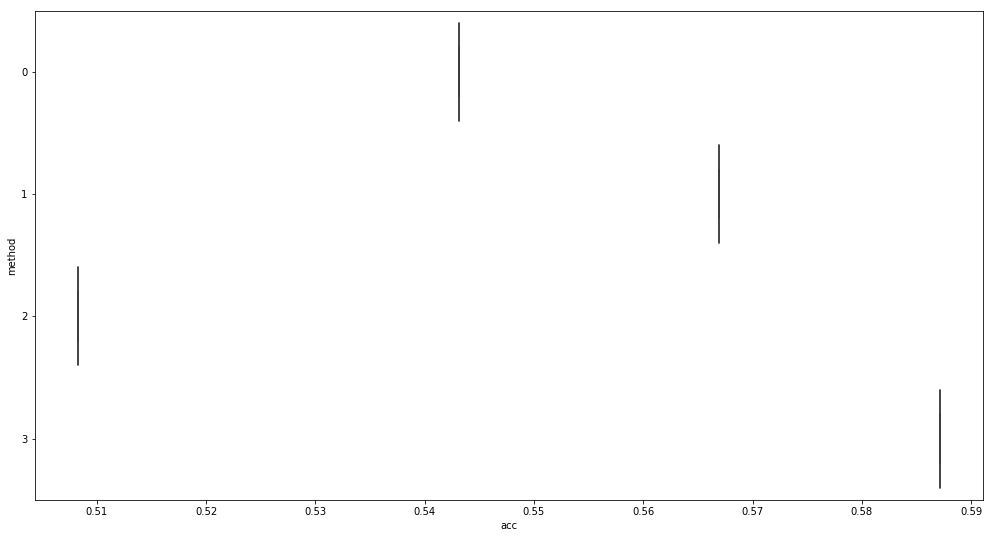

In [8]:
plt.figure(figsize=(17,9))
sns.boxplot(x='acc', y='method', data=data, orient='h')
plt.savefig('./A_min.png')

In [9]:
from json import JSONEncoder

In [10]:
j = JSONEncoder()

In [11]:
with open('./A_result_exp.json', 'w') as f:
    f.write(j.encode(el.logger))

In [12]:
#ddd.shape == (batch:3, len_sent:4, left_right:2, vocab_size:5)
#left = data[0][:, 0, :]
#right = data[0][:, 1, :]
#right.shape
#
#data = [np.array([[[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]],\
#        [[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]]]),\
#       np.array([[[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]],\
#        [[1,1,1,1,1],[5,5,5,5,5]]]),\
#       np.array([[[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]]])]